# This Notebook is for EDA and Clean-up of the provided data set for the Machine Learning course

## TODO List w/ Nice To Have's (in addition to in-line):

- Data Clean-Up/ Engineering Options:
    - Encode additional variables for use
    - Dropped List (not cleaned):
        - 'admission_type_id','admission_source_id','admission_type_value','discharge_disposition_id'
    - Determine if diag encoding is the best option
        - Might be able to use major buckets and then dummy encode them.  see here for buckets:
        https://en.wikipedia.org/wiki/List_of_ICD-9_codes

- Model Improvement:
    - Implement Class Imbalance Procedures
    - Model Stacking

- Project Completeness:
    - Add readmitted timeframe to models -- maybe as a select model and do a deep dive type of approach

- Code/ Report Improvement:

## Set Up

In [1269]:
# Standard Libraries
import pandas as pd
import numpy as np
import os
import warnings

# Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# SkLearn  Data Prep
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import category_encoders as ce
from imblearn.over_sampling import SMOTE, ADASYN

# SkLearn Measurement Libraries
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import  precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import plot_roc_curve

# SkLearn Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn import model_selection
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_blobs

# set Theme
plt.style.use('seaborn')
sns.set_theme(style="whitegrid")
warnings.filterwarnings('ignore')

In [1270]:
# Get Main Data
path = os.getcwd()
path = path +'\\medical_data\\'
file = 'data.csv'

mainData = pd.read_csv(path+file)
mainData.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide.metformin,glipizide.metformin,glimepiride.pioglitazone,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,readmitted
0,24437208,135,Caucasian,Female,[50-60),NaN,2,1,1,8,...,No,Steady,No,No,No,No,No,Ch,Yes,<30
1,29758806,378,Caucasian,Female,[50-60),NaN,3,1,1,2,...,No,No,No,No,No,No,No,No,No,NO
2,189899286,729,Caucasian,Female,[80-90),NaN,1,3,7,4,...,No,No,No,No,No,No,No,No,Yes,NO
3,64331490,774,Caucasian,Female,[80-90),NaN,1,1,7,3,...,No,No,No,No,No,No,No,Ch,Yes,NO
4,14824206,927,AfricanAmerican,Female,[30-40),NaN,1,1,7,5,...,No,No,No,No,No,No,No,No,Yes,NO


In [1271]:
# Get Admission Type Look-Up
file = 'id_lookup.csv'
admissionTypeLookUp = pd.read_csv(path+file)
admissionTypeLookUp = admissionTypeLookUp.iloc[:8]
admissionTypeLookUp['admission_type_id'] = admissionTypeLookUp['admission_type_id'].astype(int)
admissionTypeLookUp

,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available
5,6,NaN
6,7,Trauma Center
7,8,Not Mapped


In [1272]:
# Set Aside Copy of DF for Experiments
expData = mainData

In [1273]:
# set plot export paths:
plotLoc = 'C:/Users/TheCu/OneDrive/Documents/Grad-School-Docs/Machine-Learning/Final-Project-Plots/'
exportPath = 'C:/Users/TheCu/OneDrive/Documents/Grad-School-Docs/Machine-Learning/Final-Project-Plots/QuickEval/'

In [1274]:
#TEMP -- Sample Main Data to make code faster to run for debugging/ quick experiments
mainData = mainData.sample(1000)
mainData.shape

(1000, 50)

## Re-Usable Functions

In [1275]:
# Takes a DF and Producecs a Report of Null Values
def nullAnalysis(df):
    row = []
    null_summaryDF = pd.DataFrame(columns = ["Variable","Observations","Nulls","Null_Per","Num_Unique","Type"])
    for column in df:
        var = column
        countOfObs = len(df[var])
        countOfNull = df[var].isnull().sum()
        perOfNull = round((100 * countOfNull) / countOfObs,3)
        numUnique = df[var].nunique()
        type  = df[var].dtypes
        # Append to Summary DF
        row = [var, countOfObs,countOfNull,perOfNull,numUnique,type]
        df_length = len(null_summaryDF)
        null_summaryDF.loc[df_length] = row
    # Get Summary Stats
    countofVars = len(null_summaryDF)
    countofNotNull = (null_summaryDF['Nulls'] == 0).sum()
    countofNull = (null_summaryDF['Nulls'] != 0).sum()
    print(f"Count of Variables:",countofVars)
    print(f"Count of Variables without nulls:",countofNotNull)
    print(f"Count of Variables with null :",countofNull)
    # Format Summary
    summaryDF = null_summaryDF[null_summaryDF['Nulls'] != 0].sort_values(by=['Nulls'],ascending=False)
    return summaryDF

In [1276]:
# Takes a DF, list of variable,and an order and returns a DF w/ ordinal encoding
def OrdinalEncoderFunc (df,listOfVars,order):
    enc = OrdinalEncoder(categories=[order])
    for col in listOfVars:
        col=col
        df[col] = enc.fit_transform(df[[col]])
    return df

In [1277]:
def target_encoder(df, var, var1): #var1 needs to be a target (numerical not categorical)
    tenc = ce.TargetEncoder()
    df[var] = (tenc.fit_transform(df[[var]], df[[var1]]))
    return df

In [1278]:
# Custom Clean-Up Function For This Dataset -- 1
def EncodeResponse (df):
    # Execute Encoding
    dummyTemp = pd.get_dummies(df['readmitted'],prefix='readmitted_')
    df = df.join(dummyTemp)
    # Customize/ Clean-Up
    ## Make 'readmitted' more logical so it is 0 when no and 1 when yes
    df = df.drop(columns=['readmitted']) # Drop Old Readmitted Column
    df = df.rename(columns={'readmitted__NO': 'readmitted'}) # Rename encoded column
    df = df.dropna(subset=['readmitted']) # drop puzzling 1 nan value
    df['readmitted'] = df['readmitted'].map({0:1, 1:0}) # reverse encoding to make logical
    return df


In [1279]:
# Custom Clean-Up Function For This Dataset -- 2
# TODO: Clean-up for demographic Vars (age, gender, race)

def AdditionalClean (df):
    #1 - Null Clean-Up2 -- Fillna's for variables with nulls that have value to keep
    df['race'] = df['race'].fillna('Unknown')
    #2 - Race to Dummy Vars
    dummyTemp = pd.get_dummies(df['race'],prefix='race_')
    df = df.join(dummyTemp)
    df = df.drop(columns=['race'])
    #2 - Encode Gender
    number = LabelEncoder()
    df['gender'] = number.fit_transform(df['gender']) # F -> 1, M -> 0, Unknown -> 2
    #3 - Encode diabetesMed
    df['diabetesMed'] = number.fit_transform(df['diabetesMed']) # Yes -> 1, No -> 0
    #4 Custom Encode 1 -  A1Cresult
    mapping_a1 = {'None':0,'Norm':0,'>7':1,'>8':2}
    df['A1Cresult'] = df['A1Cresult'].map(mapping_a1)
    #5 Custom Encode 2 -  max_glu_serum
    mapping_glu = {'None':0,'Norm':0,'>200':1,'>300':2}
    df['max_glu_serum'] = df['max_glu_serum'].map(mapping_glu)
    #6 Custom Encode 3 - change
    mapping_change = {'No':0,'Ch':1,}
    df['change'] = df['change'].map(mapping_change)
    #7 - Convert Age Buckets to Single Numeric
    df['age'] = df['age'].str[1:3]
    df['age'] = df['age'].str.rstrip('-')
    df['age'] = df['age'].astype('int')
    df = df.rename(columns={'age': 'age_10yrStart'})
    return df

In [1280]:
# Main Clean DF Function -- Wraps Clean-Up Steps into one function so I can run on multiple versions of a DF
## Does not include steps for cleaning response variable.

def Clean_DF_Wrapper (df_to_clean,ordEncode_Vars,ordEncode_order,medCols):

    # Null Clean-Up1 -- Drop Columns with high % of nulls, that aren't worth filling
    df_to_clean = df_to_clean.drop(columns=['weight','medical_specialty','payer_code'])

    # Diag Clean-Up
    ## If diag_2 is null, then use diag_3.  If diag_1 is null, then use diag_2
    ## Solves all but 1 null Diag1, which is dropped
    ## TODO: Determine how to drop value from column that I pull from.
    df_to_clean['diag_2'] = df_to_clean['diag_2'].fillna(df_to_clean['diag_3'])
    df_to_clean['diag_1'] = df_to_clean['diag_1'].fillna(df_to_clean['diag_2'])
    df_to_clean = df_to_clean.dropna(subset=['diag_1'])

    # Remove Deceased Patients
    ## Note: The research question is about predicting what patients will be re-admitted.
    ## In order to not skew the results, patients who died while admitted should be removed from the prediction
    ## Note: I only removed cases that explicity said the patient expired. not hospice patients (13,14)
    expCodes = ['11','19','20','21']
    df_to_clean = df_to_clean[~df_to_clean['discharge_disposition_id'].isin(expCodes)]

    # Call OrdinalEncoder Function
    df_to_clean  = OrdinalEncoderFunc(df_to_clean,ordEncode_Vars,ordEncode_order)

    # Add Variable For Number of Medications
    df_to_clean['num_of_meds'] = df_to_clean[medCols].ne(0).sum(axis=1)

    # Add Variable for Medication Level Up Or Down
    ## In the Medication columns 1 signifies that dosage decreased, 3 signifies that dosage increased
    ## This counts the number of 1 and coverts to a negative, then the adds the number of 3
    ## Result indicates the net level of medication change
    df_to_clean['med_level_direction'] = ((df_to_clean[medCols] == 1).sum(axis=1)*-1) + \
                                  (df_to_clean[medCols] == 3).sum(axis=1)

    # Call Function w/ all custom clean-up steps
    df_to_clean = AdditionalClean(df_to_clean)

    return df_to_clean

In [1281]:
# Clean DF Function For Response -- Wraps Steps into one function so I can run on multiple versions of a DF
## Seems strange that it only calls another function, wanted structure in case I added other steps

def Clean_ResponseVar (df_to_clean):
    df_to_clean = EncodeResponse(df_to_clean)
    return df_to_clean


In [1282]:
#  Split function - Takes a df and list of predictor vars and specified response var and
##  returns x/y test/train sets.
## Note: update params if you want reproducable splits or not
## Note: set test size to 20%

def testTrainSplit (df, PredictorVar,ResponseVar):
    # Split into training/test
    x = df[PredictorVar]
    y = df[ResponseVar]
    # Split Data Set Seed NP Random
    np.random.seed(1) # seed np random
    ## split data - use "random_state = any number (42) if you want reproducable splits.
    ### Remove random-state if you want random
    x_train, x_test, y_train, y_test = train_test_split(x,y, random_state=42, test_size = 0.2)
    return x_train, x_test, y_train, y_test


In [1283]:
# Takes a model, and test sets and returns and ROC Curve w/ AUC value

def ROC_Curve_Plot(model,roc_x_test,roc_y_test):
    probas = model.predict_proba(roc_x_test) # get the probability distribution
    fpr, tpr, thresholds = roc_curve(roc_y_test, probas[:,0], pos_label=0) # get false and true positive rates
    roc_auc = auc(fpr, tpr) # get area under curve
    # PLOT ROC curve
    plt.figure(dpi=150)
    plt.plot(fpr, tpr, lw=1, color='green', label=f'AUC = {roc_auc:.3f}')
    plt.plot([0,1], [0,1], '--k', lw=0.5, label='Random')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.legend()
    return plt

In [1284]:
# Takes a model and various split sets and returns a CM plot w/ Accuracy

def createConfMatrix (regObj, y_test, y_pred, x_test):
    # Logistic Regression -- Step 5 -- Create Confusion Matrix
    cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
    cm.columns.name = 'Predicted'
    cm.index.name = 'True'
    # Logistic Regression -- Step 6 -- Calc Accuracy From Test Set
    score = regObj.score(x_test, y_test)
    score = round(score,4)
    return cm, score


In [1285]:
# Takes test and predicted sets and returns precision/recall metrics
def summaryStats (model_name, y_test, y_pred, SummaryDF):
    # Collect Stats
    row =[]
    accuracy = round(accuracy_score(y_test, y_pred),4)
    precision = round(precision_score(y_test, y_pred),4)
    recall = round(recall_score(y_test, y_pred),4)
    f1 = round(f1_score(y_test, y_pred),4)
    # Collect Results
    row = [model_name,accuracy, precision, recall, f1]
    # append stats to Summary Stats DF
    df = SummaryDF
    df_length = len(df)
    df.loc[df_length] = row
    return df

In [1286]:
# Takes a model and returns a Feature Importance Plot

def FeatureImportance (model,featureList):
    # Best Tree-- Plot Most Important Features
    importances = model.feature_importances_
    #Convert Array to DF
    feature_importances = pd.Series(importances, index=featureList)
    feature_importances = feature_importances.to_frame().reset_index()
    feature_importances = feature_importances.rename(columns={'index':'feature',0:'impDecrease'})
    feature_importances = feature_importances.sort_values(by='impDecrease',ascending=False)
    #std = np.std([tree.feature_importances_ for tree in cv_bestTree.estimators_], axis=0)
    # Create Plot
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize = (6,6), dpi=200)
    ax = sns.barplot(x="impDecrease", y="feature", data=feature_importances,color="blue")
    ax.set_title("Feature importance")
    ax.set_ylabel("Feature")
    ax.set_xlabel("Impurity Decrease")
    fig.tight_layout()
    return feature_importances, fig

In [1287]:
# Takes a DF and returns an elbow plot for KMeans in order to determine the proper K Value
## Think of as KMeans Pre-Analysis

def KMeansElbowPlot(df):
    # Elbow Method -- To Set K Range
    k_rng = range(1,10)
    # sum of square error
    sse = []
    for k in k_rng:
        km = KMeans(n_clusters=k)
        km.fit(df)
        sse.append(km.inertia_)
    # Elbow Plot w / SSE
    plt.xlabel('K')
    plt.ylabel('SSE')
    plt.plot(k_rng,sse)
    return plt

In [1288]:
# Takes a DF, list of Predictor Vars, and Response Var and returns an elbow plot to determine optimal P.C.'s

def PCA_PreProcess_Elbow(df,PredictorVar,ResponseVar):
    # PCA -- CV
    upper = len(PredictorVar)
    row =[]
    pca_Result = pd.DataFrame(columns = ["Number_Variables","MSE",'RMSE',"Variance_Explained"])
    kf = model_selection.KFold( n_splits=10, shuffle=True, random_state=1)
    # Function Call To prep train/test
    for i in range(upper):
        x_train, x_test, y_train, y_test  = testTrainSplit(df, PredictorVar[:i+1], ResponseVar)
        pca = PCA()
        x = pca.fit_transform(scale(x_test))
        regr = LinearRegression()
        regr.fit(x_train, y_train)
        score = -1*model_selection.cross_val_score(regr, x_test, y_test, cv=kf,
                                               scoring='neg_mean_squared_error').mean()
        varExplained = 1-(pca.explained_variance_ratio_[i])
        RMSE = np.sqrt(score)
        row = [i,score,RMSE,varExplained]
        df_length = len(pca_Result)
        pca_Result.loc[df_length] = row
    # PCA -- plot
    sns.set_style("whitegrid")
    sns.set(rc = {'figure.figsize':(5,5)})
    fig, (ax1,ax2) = plt.subplots(ncols=2,sharex=True, sharey=False, figsize=(15,9))
    sns.lineplot(
        data=pca_Result, ax=ax1,
        x="Number_Variables", y="MSE",
        marker="o", dashes=False)
    sns.lineplot(
        data=pca_Result, ax=ax2,
        x="Number_Variables", y="Variance_Explained",
        marker="o", dashes=False)
    return plt

In [1289]:
# Run PCA on a given set after determined optimal number of features (m) w/ the Pre-Process Function.

def PCA_Actual(df,PCA_relevant_features,numFeatures):
    # Make a temp set w/ just PCA_PredictorVars
    tempSet = df[PCA_relevant_features]
    # PCA -- Run Actual on Set w/ Num Features Defined On Temp Set -- Produce Array
    pca_BestM = PCA(n_components=numFeatures, random_state=1)
    X_scaled = scale(tempSet)
    pca_BestM.fit(X_scaled)
    X_pca_bestM = pca_BestM.transform(X_scaled)
    # Convert Array into DF
    PC_Cols = []
    for i in range(numFeatures):
        num=str(i+1)
        PC_Cols.append("PC"+num)
    PCA_ResultsDF = pd.DataFrame(X_pca_bestM, columns=PC_Cols)
    #df = df.reset_index()
    #df = df.join(PCA_ResultsDF)
    df = pd.merge(df,PCA_ResultsDF, left_index=True, right_index=True)
    #print(len(df))
    # Drop PredictorVars -- replace w/ P.C
    df = df.drop(columns=PCA_relevant_features)
    # reset new Predictor Var List
    PredictorVar = df.columns.values.tolist()
    return df, PredictorVar

In [1290]:
def quickModelComparison(models,qe_x_train,qe_x_test, qe_y_train,qe_y_test, qe_summaryDF):
    i=0
    sc_X = StandardScaler()
    qe_x_train_scaled = sc_X.fit_transform(qe_x_train)
    qe_x_test_scaled = sc_X.transform(qe_x_test)
    for model in models:
        # Model Name -- TODO
        model_name = str(models[i])
        split_string = model_name.split("(", 1)
        model_name = split_string[0]
        i=i+1
        #fit
        model.fit(qe_x_train_scaled,qe_y_train)
        # Make Predictions
        y_pred_qe = model.predict(qe_x_test_scaled)
        # summary
        qe_summaryDF = summaryStats(model_name,qe_y_test, y_pred_qe, qe_summaryDF)
        # PLOT ROC curve -- TODO
    return qe_summaryDF

## General EDA

In [1291]:
# Data Shape
print(f"Data shape:",mainData.shape)

Data shape: (1000, 50)


In [1292]:
mainData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 64345 to 25356
Data columns (total 50 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   encounter_id              1000 non-null   int64 
 1   patient_nbr               1000 non-null   int64 
 2   race                      973 non-null    object
 3   gender                    1000 non-null   object
 4   age                       1000 non-null   object
 5   weight                    34 non-null     object
 6   admission_type_id         1000 non-null   int64 
 7   discharge_disposition_id  1000 non-null   int64 
 8   admission_source_id       1000 non-null   int64 
 9   time_in_hospital          1000 non-null   int64 
 10  payer_code                581 non-null    object
 11  medical_specialty         483 non-null    object
 12  num_lab_procedures        1000 non-null   int64 
 13  num_procedures            1000 non-null   int64 
 14  num_medications    

In [1293]:
# Describe
mainData.describe(include='all')

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide.metformin,glipizide.metformin,glimepiride.pioglitazone,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,readmitted
count,1.000000e+03,1.000000e+03,973,1000,1000,34,1000.000000,1000.000000,1000.000000,1000.000000,...,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
unique,NaN,NaN,5,2,10,4,NaN,NaN,NaN,NaN,...,1,4,2,1,1,1,1,2,2,3
top,NaN,NaN,Caucasian,Female,[70-80),[75-100),NaN,NaN,NaN,NaN,...,No,No,No,No,No,No,No,No,Yes,NO
freq,NaN,NaN,749,530,262,16,NaN,NaN,NaN,NaN,...,1000,523,995,1000,1000,1000,1000,571,750,623
mean,1.621514e+08,5.533546e+07,NaN,NaN,NaN,NaN,2.138000,3.641000,5.484000,4.401000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.025218e+08,3.872281e+07,NaN,NaN,NaN,NaN,1.493046,5.214721,4.210876,3.070118,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,2.931180e+05,1.304100e+04,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,8.444511e+07,2.354240e+07,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,2.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.474139e+08,4.610733e+07,NaN,NaN,NaN,NaN,2.000000,1.000000,7.000000,4.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2.246724e+08,8.811953e+07,NaN,NaN,NaN,NaN,3.000000,4.000000,7.000000,6.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1294]:
numericFeatures = mainData.select_dtypes(include= np.number)
numericFeatures = numericFeatures.drop(columns=['encounter_id','patient_nbr'])
numericFeatures.nunique()

admission_type_id            7
discharge_disposition_id    17
admission_source_id          8
time_in_hospital            14
num_lab_procedures          93
num_procedures               7
num_medications             50
number_outpatient            7
number_emergency             7
number_inpatient             7
number_diagnoses             9
dtype: int64

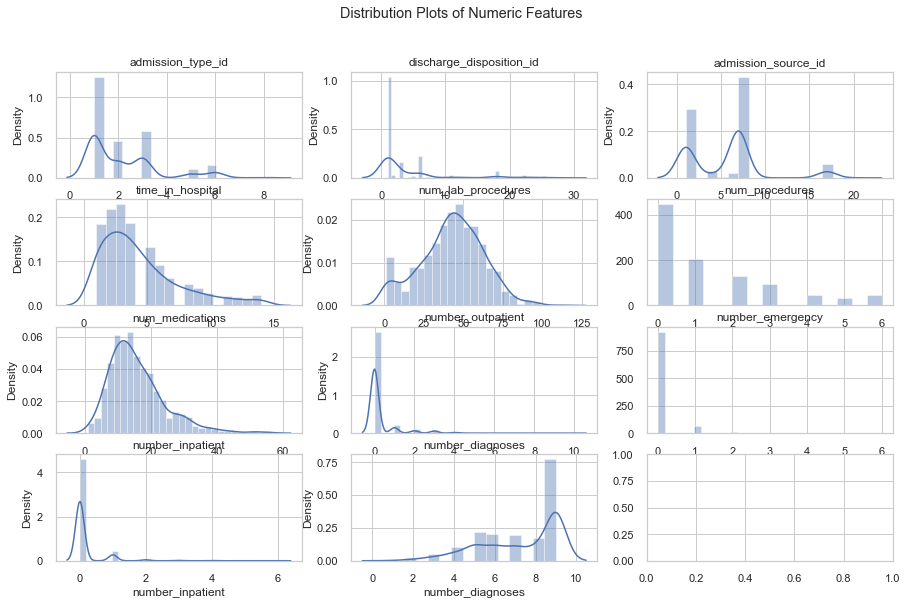

In [1295]:
# Distribution Plots

fig, axes = plt.subplots(4,3, sharex=False, sharey=False, figsize=(15,9))
fig.suptitle('Distribution Plots of Numeric Features')

sns.distplot(numericFeatures['admission_type_id'], ax=axes[0,0], kde=True).set(title='admission_type_id')
sns.distplot(numericFeatures['discharge_disposition_id'], ax=axes[0,1], kde=True).set(title='discharge_disposition_id')
sns.distplot(numericFeatures['admission_source_id'], ax=axes[0,2], kde=True).set(title='admission_source_id')
sns.distplot(numericFeatures['time_in_hospital'], ax=axes[1,0], kde=True).set(title='time_in_hospital')
sns.distplot(numericFeatures['num_lab_procedures'], ax=axes[1,1], kde=True).set(title='num_lab_procedures')
sns.distplot(numericFeatures['num_procedures'], ax=axes[1,2], kde=False).set(title='num_procedures')
sns.distplot(numericFeatures['num_medications'], ax=axes[2,0], kde=True).set(title='num_medications')
sns.distplot(numericFeatures['number_outpatient'], ax=axes[2,1], kde=True).set(title='number_outpatient')
sns.distplot(numericFeatures['number_emergency'], ax=axes[2,2], kde=False).set(title='number_emergency')
sns.distplot(numericFeatures['number_inpatient'], ax=axes[3,0], kde=True).set(title='number_inpatient')
sns.distplot(numericFeatures['number_diagnoses'], ax=axes[3,1], kde=True).set(title='number_diagnoses')

plt.show()

In [1296]:
# sns.pairplot(numericFeatures)

## General Data Clean-Up

In [1297]:
# Print Null Summary
nullSummary = nullAnalysis(mainData)
nullSummary

Count of Variables: 50
Count of Variables without nulls: 43
Count of Variables with null : 7


,Variable,Observations,Nulls,Null_Per,Num_Unique,Type
5,weight,1000,966,96.6,4,object
11,medical_specialty,1000,517,51.7,37,object
10,payer_code,1000,419,41.9,15,object
2,race,1000,27,2.7,5,object
20,diag_3,1000,17,1.7,213,object
19,diag_2,1000,4,0.4,198,object
18,diag_1,1000,1,0.1,223,object


In [1298]:
# Specify Medications for Encoding
medCols = ['metformin','repaglinide','nateglinide','chlorpropamide','glimepiride',
            'acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone',
            'rosiglitazone','acarbose','miglitol','troglitazone','tolazamide','examide',
            'citoglipton','insulin','glyburide.metformin','glipizide.metformin','glimepiride.pioglitazone',
            'metformin.rosiglitazone','metformin.pioglitazone']

# Set Function Params
df_to_clean = mainData
ordEncode_Vars = medCols
ordEncode_order = ['No','Down','Steady','Up']

cleanDF = Clean_DF_Wrapper(df_to_clean,ordEncode_Vars,ordEncode_order,medCols)
cleanDF = Clean_ResponseVar(cleanDF)
cleanDF.sample(3)

,encounter_id,patient_nbr,gender,age_10yrStart,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,...,med_level_direction,race__AfricanAmerican,race__Asian,race__Caucasian,race__Hispanic,race__Other,race__Unknown,readmitted__<30,readmitted__>30,readmitted
25662,248824662,32111460,0,60,1,1,7,2,13,0,...,1,0,0,1,0,0,0,0,1,1
63192,271538064,102555162,1,60,2,1,7,3,95,0,...,-1,0,1,0,0,0,0,0,0,0
12108,103816296,13478049,0,70,2,1,1,3,41,0,...,0,0,0,0,0,0,1,0,0,0


In [1299]:
# Re-Run Null Summary
nullSummary = nullAnalysis(cleanDF)
nullSummary

Count of Variables: 56
Count of Variables without nulls: 54
Count of Variables with null : 2


,Variable,Observations,Nulls,Null_Per,Num_Unique,Type
16,diag_3,984,16,1.626,212,object
15,diag_2,984,2,0.203,197,object


In [1300]:
# Diag Encoders
target_encoder(cleanDF,'diag_1', 'readmitted')
target_encoder(cleanDF,'diag_2', 'readmitted')
target_encoder(cleanDF,'diag_3', 'readmitted')
cleanDF.sample(3)

,encounter_id,patient_nbr,gender,age_10yrStart,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,...,med_level_direction,race__AfricanAmerican,race__Asian,race__Caucasian,race__Hispanic,race__Other,race__Unknown,readmitted__<30,readmitted__>30,readmitted
57456,165134904,92649726,0,40,1,1,7,3,44,0,...,0,0,0,1,0,0,0,0,1,1
54683,195144564,89034768,0,70,3,1,1,3,72,1,...,0,0,0,1,0,0,0,0,1,1
50496,167064480,84318354,1,40,1,1,7,2,41,0,...,0,0,0,1,0,0,0,0,0,0


### Join Datasets -- Replace Look-Up Values With Literal Values

In [1301]:
# Add Admission Type Values (Note: Did not drop ID)

# Add Column
cleanDF.insert(5,"admission_type_value", 0)

# Left Join
cleanDF = pd.merge(cleanDF,admissionTypeLookUp,on='admission_type_id')

# Replace Values
cleanDF['admission_type_value'] = cleanDF['description']
cleanDF = cleanDF.drop(columns=['description'])
cleanDF.sample(3)

,encounter_id,patient_nbr,gender,age_10yrStart,admission_type_id,admission_type_value,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,med_level_direction,race__AfricanAmerican,race__Asian,race__Caucasian,race__Hispanic,race__Other,race__Unknown,readmitted__<30,readmitted__>30,readmitted
857,293050218,80147826,0,60,2,Urgent,6,1,3,45,...,0,0,0,1,0,0,0,0,0,0
402,41140638,10348749,0,40,1,Emergency,1,7,4,54,...,1,0,0,1,0,0,0,0,0,0
636,169054248,90663453,1,40,3,Elective,1,2,1,38,...,0,0,0,1,0,0,0,0,0,0


# Run Models

In [1302]:
# create copy of cleanDF
tempModelingDF = cleanDF

In [1303]:
# Create DF for Capturing Model Results
statRow = []
summaryStatsDF = pd.DataFrame(columns = ['Model','Accuracy','Precision','Recall','F1'])

## Prep -- Split Data
TODO: This is the wrong place - should be earlier in the code - adding here for now to just get the models working
and because I was confused by where to split based on needing to clean the response variable (ie should I split twice)

TODO: Don't yet know how to deal with multiple response variables.  First pass will keep it simple and only predict
if readmitted is yes/no.  Will need to add timeline response variables later

In [1304]:
# Drop columns that are not needed
varsToDrop = ['admission_type_id','admission_source_id','admission_type_value','discharge_disposition_id',]
# These are variables w/o encoding or appropriate feature engineering

tempModelingDF = tempModelingDF.drop(columns=varsToDrop)

# Parking Lot -- Features removed from drop list
# 'A1Cresult','max_glu_serum', 'time_in_hospital','num_lab_procedures','num_procedures','num_medications',
# 'number_outpatient','number_emergency','number_inpatient','number_diagnoses','diabetesMed',
# 'change', 'gender', 'age_10yrStart','diag1','diag2',diag3'

# Identifiers to Drop
tempModelingDF = tempModelingDF.drop(columns=['encounter_id','patient_nbr',])

# TEMP - Additional Response Vars to Drop
tempModelingDF = tempModelingDF.drop(columns=['readmitted__<30','readmitted__>30'])

In [1305]:
# Set or Reset Test/Train Split
# Params
df=tempModelingDF #TODO - Change From temp DF
ResponseVar = 'readmitted' #TODO - Change from single response variable
PredictorVar_orig = df.columns.values.tolist()
PredictorVar_orig.remove(ResponseVar)

# Function Call To prep train/test
x_train, x_test, y_train, y_test  = testTrainSplit(df, PredictorVar_orig, ResponseVar)

# Need to reset indexes and drop old index column to work w/ PCA
x_train = x_train.reset_index().drop(columns=['index'])
y_train = y_train.reset_index().drop(columns=['index'])
x_test = x_test.reset_index().drop(columns=['index'])
y_test = y_test.reset_index().drop(columns=['index'])

In [1306]:
# Class Balancing

print('*******************************************************************************')
print("Before Balancing:")
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)
print()
print(f"y_train value counts:",y_train.value_counts())
print('*******************************************************************************')
sm = SMOTE(random_state=2)
x_train, y_train = sm.fit_resample(x_train, y_train)
print('*******************************************************************************')
print("After Balancing:")
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)
print()
print(f"y_train value counts:",y_train.value_counts())
print('*******************************************************************************')

*******************************************************************************
Before Balancing:
x_train shape:  (787, 48)
y_train shape:  (787, 1)
x_test shape:  (197, 48)
y_test shape:  (197, 1)

y_train value counts: readmitted
0             477
1             310
dtype: int64
*******************************************************************************
*******************************************************************************
After Balancing:
x_train shape:  (954, 48)
y_train shape:  (954, 1)
x_test shape:  (197, 48)
y_test shape:  (197, 1)

y_train value counts: readmitted
1             477
0             477
dtype: int64
*******************************************************************************


In [1307]:
print("Complete List of Predicator Vars:")
PredictorVar_orig

Complete List of Predicator Vars:


['gender',
 'age_10yrStart',
 'time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'diag_1',
 'diag_2',
 'diag_3',
 'number_diagnoses',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'citoglipton',
 'insulin',
 'glyburide.metformin',
 'glipizide.metformin',
 'glimepiride.pioglitazone',
 'metformin.rosiglitazone',
 'metformin.pioglitazone',
 'change',
 'diabetesMed',
 'num_of_meds',
 'med_level_direction',
 'race__AfricanAmerican',
 'race__Asian',
 'race__Caucasian',
 'race__Hispanic',
 'race__Other',
 'race__Unknown']

In [1308]:
# Initial Quick Eval

# Create DF for Capturing Model Results
statRow = []
qe_summaryDF = pd.DataFrame(columns = ['Model','Accuracy','Precision','Recall','F1'])

# Set models
rf_qe = RandomForestClassifier(n_estimators=500, max_leaf_nodes=32,n_jobs=-1)
nn_qe = MLPClassifier(hidden_layer_sizes=(256,128,64,32),activation="relu",random_state=1)
knn_qe = KNeighborsClassifier(n_neighbors=2)
gb_qe = gb_qe = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0)

# Models List
models = [rf_qe,nn_qe,knn_qe,gb_qe]

## Call Function
qe_summaryDF = quickModelComparison(models,x_train, x_test,
                                    y_train, y_test, qe_summaryDF ) # model list, X sets, y sets, summary df
print("quick evaluation report with vanilla test/train split:")
qe_summaryDF

quick evaluation report with vanilla test/train split:


,Model,Accuracy,Precision,Recall,F1
0,RandomForestClassifier,0.7259,0.5942,0.6119,0.6029
1,MLPClassifier,0.6548,0.4937,0.5821,0.5342
2,KNeighborsClassifier,0.6447,0.4651,0.2985,0.3636
3,GradientBoostingClassifier,0.7056,0.5600,0.6269,0.5915


## Prep -- Run PCA on Cont. Numeric Features

In [1309]:
x_train_pca = x_train
y_train_pca = y_train
x_test_pca = x_test
y_test_pca = y_test


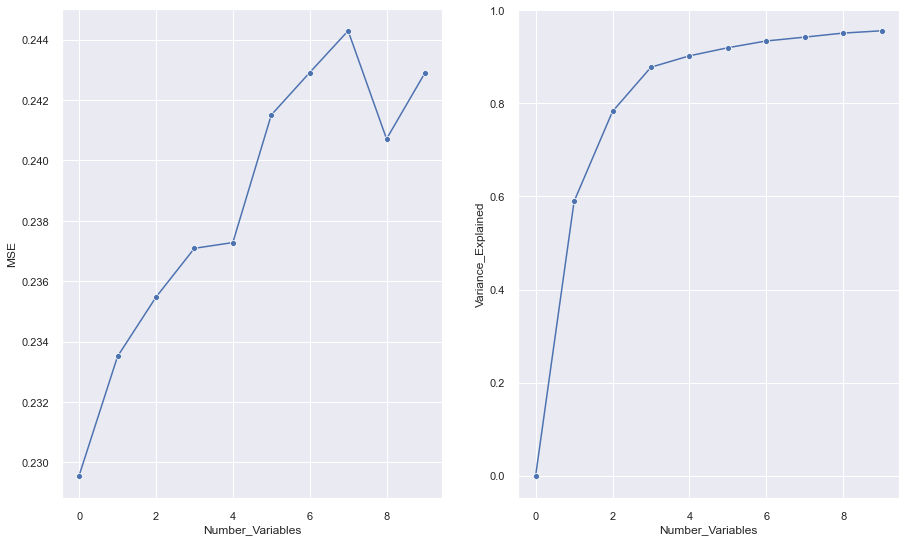

In [1310]:
# PCA Pre-Run on Complete Dataframe to Identify right Hyperparams
df = tempModelingDF
PCA_relevant_features = ['age_10yrStart','time_in_hospital','num_lab_procedures',
                    'num_medications','number_outpatient','number_emergency','number_inpatient',
                    'number_diagnoses','num_procedures','num_of_meds']
# parking lot: (empty)

PCA_ResponseVar = 'readmitted'

PCA_PreProcess_Elbow(df,PCA_relevant_features,PCA_ResponseVar)
plt.show()

In [1311]:
# Call PCA Function for Test/Train Sets.  Also returns new Predictor Var list for use in later models

features = PCA_relevant_features
PCs = 4

x_train_pca, PredictorVar_pca = PCA_Actual(x_train_pca,features,PCs) # set, features for PCA, number of P.Cs
x_test_pca, PredictorVar_pca = PCA_Actual(x_test_pca,features,PCs) # set, features for PCA, number of P.Cs

In [1312]:
# Initial Quick Eval w/ PCA

# Create DF for Capturing Model Results
statRow = []
qe_summaryDF_wPCA = pd.DataFrame(columns = ['Model','Accuracy','Precision','Recall','F1'])

# Set models -- USES SAME AS EVAL w/o PCA ABOVE

# Models List -- USES SAME AS EVAL w/o PCA ABOVE

## Call Function
qe_summaryDF_wPCA = quickModelComparison(models,x_train_pca, x_test_pca,
                                         y_train_pca, y_test_pca,qe_summaryDF_wPCA ) # model list, X sets, y sets, summary df
print("quick evaluation report with test/train split with PCA:")
qe_summaryDF_wPCA

quick evaluation report with test/train split with PCA:


,Model,Accuracy,Precision,Recall,F1
0,RandomForestClassifier,0.7208,0.5857,0.6119,0.5985
1,MLPClassifier,0.6751,0.5169,0.6866,0.5897
2,KNeighborsClassifier,0.6954,0.5854,0.3582,0.4444
3,GradientBoostingClassifier,0.7005,0.5571,0.5821,0.5693


## Model Intro:

In [1314]:
# Sets to Use:
x_train_Active = x_train
x_test_Active = x_test
y_train_Active = y_train
y_test_Active= y_test
#Parking lot _pca

# Feature List
featureList = PredictorVar_orig # Parking Lot: PredictorVar_pca

# Scale X sets:
sc_X = StandardScaler()
x_train_Active = sc_X.fit_transform(x_train)
x_test_Active = sc_X.transform(x_test)

## Random Forest

In [1315]:
print("starting RF")
# Random Forest
## Set and Fit Model
rf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=32,n_jobs=-1)
rf.fit(x_train_Active,y_train_Active)

## Make Predictions
y_pred_rf = rf.predict(x_test_Active)
print("done RF")

starting RF
done RF


start plot


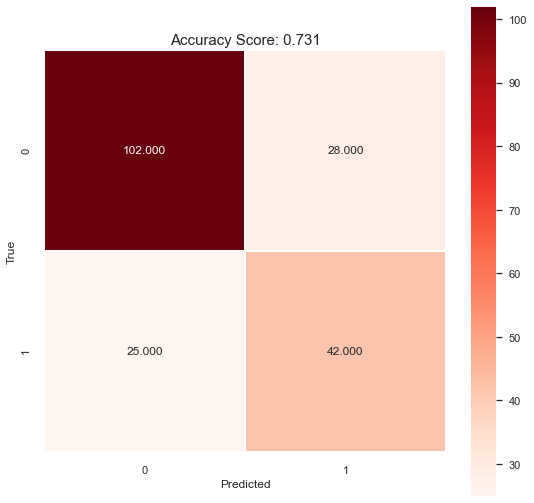

In [1316]:
print("start plot")
cm, score = createConfMatrix(rf,y_test_Active, y_pred_rf, x_test_Active) # model, y_test, y_pred, x_test

# plot result
plt.figure(figsize=(9,9))
fig= sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Reds');
all_sample_title = "Accuracy Score: " + score.astype('str')
plt.title(all_sample_title, size = 15);
plt.savefig(plotLoc+'RF_CM.png')

In [1317]:
# Random Forest -- Precision/Recall Scores

## Set Params
model_name = "Random Forest"

## Call Function
summaryDF = summaryStats(model_name,y_test_Active, y_pred_rf, summaryStatsDF) # modelName(str), y_test, y_pred, df
summaryDF

,Model,Accuracy,Precision,Recall,F1
0,Random Forest,0.731,0.6,0.6269,0.6131


Start RF ROC Plot


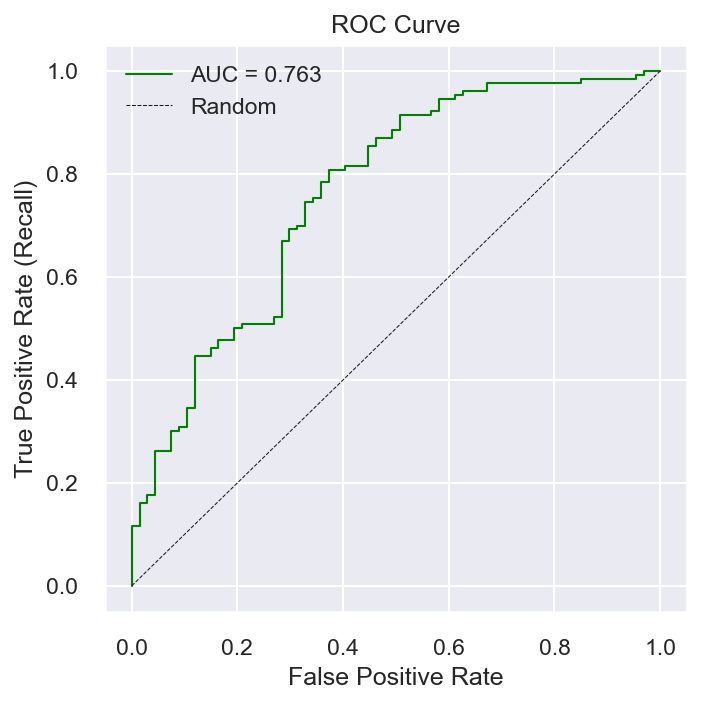

<Figure size 360x360 with 0 Axes>

In [1318]:
# ROC Curve/ AUC Score
print("Start RF ROC Plot")

## Call Function
ROC_Curve_Plot(rf,x_test_Active, y_test_Active) # model, x_test, y_test
plt.show()
plt.savefig(plotLoc+'RF_ROC.png')

Start RF Feature Importance


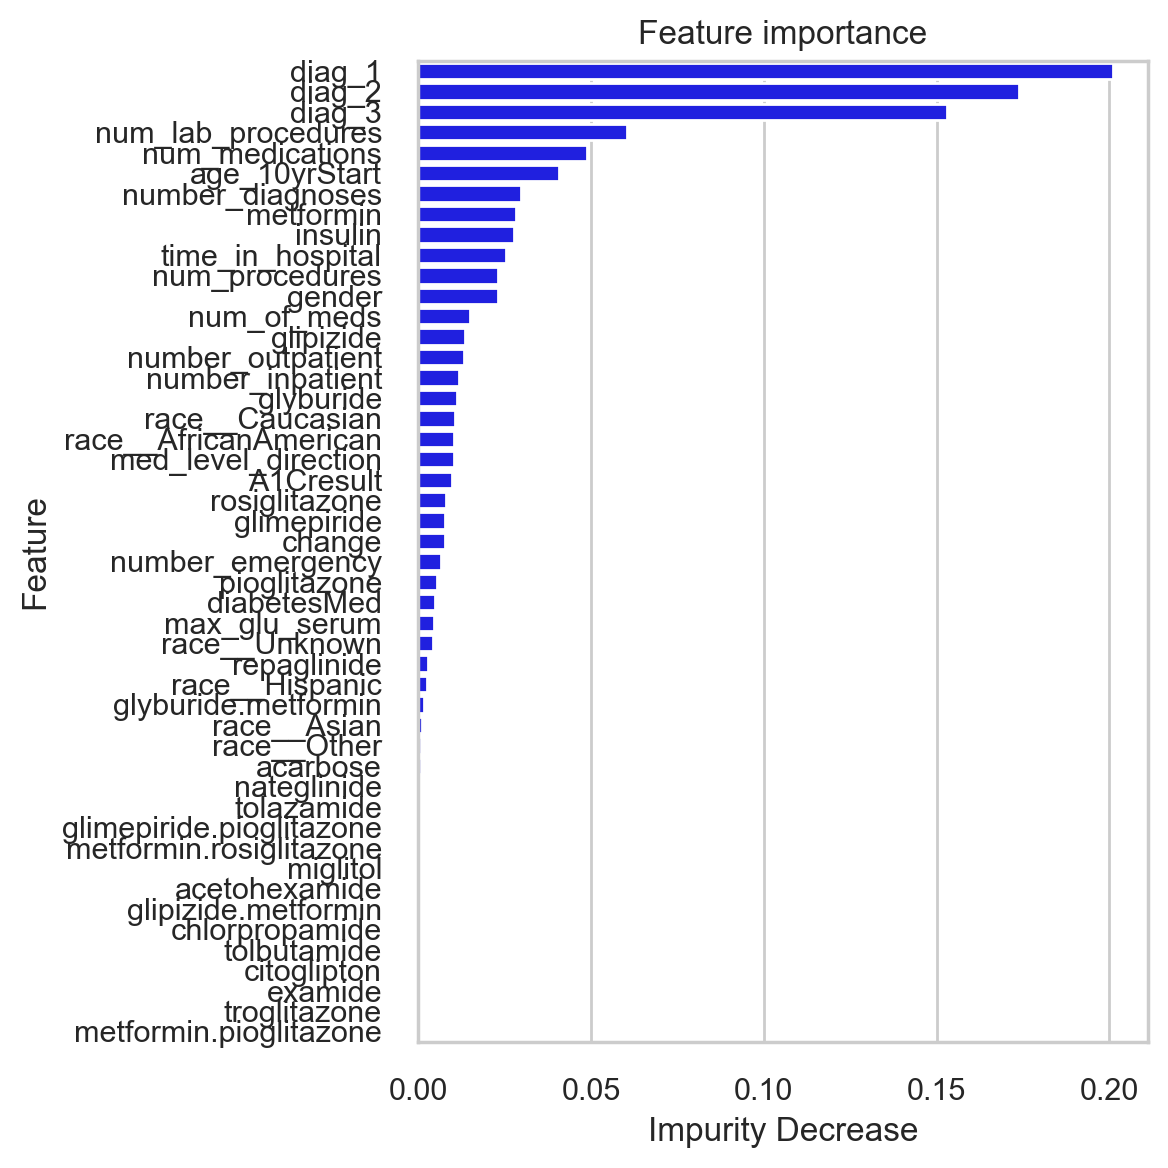

In [1319]:
# Random Forest -- Feature Importance -- Plot Most Important Features
print("Start RF Feature Importance")

feature_importances, fig = FeatureImportance(rf,featureList) #model, featureList
fig.show()
plt.savefig(plotLoc+'RF_Feature-Importance.png')

## Gradient Boosting

In [1320]:
print("starting GB")
# Random Forest
## Set and Fit Model
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                max_depth=1, random_state=0).fit(x_train, y_train)
gb.fit(x_train,y_train)

## Make Predictions
y_pred_gb = gb.predict(x_test)
print("done predict gb")

starting GB
done predict gb


start gb plot


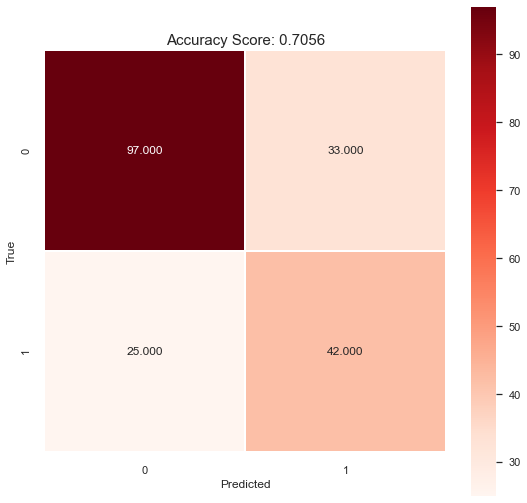

In [1321]:
print("start gb plot")
cm, score = createConfMatrix(gb,y_test, y_pred_gb, x_test) # model, y_test, y_pred, x_test

# plot result
plt.figure(figsize=(9,9))
fig= sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Reds');
all_sample_title = "Accuracy Score: " + score.astype('str')
plt.title(all_sample_title, size = 15);
plt.savefig(plotLoc+'RF_CM.png')

In [1322]:
# Random Forest -- Precision/Recall Scores

## Set Params
model_name = "Gradient Boost"

## Call Function
summaryDF = summaryStats(model_name,y_test, y_pred_gb, summaryStatsDF) # modelName(str), y_test, y_pred, df
summaryDF

,Model,Accuracy,Precision,Recall,F1
0,Random Forest,0.7310,0.60,0.6269,0.6131
1,Gradient Boost,0.7056,0.56,0.6269,0.5915


Start GB ROC Plot


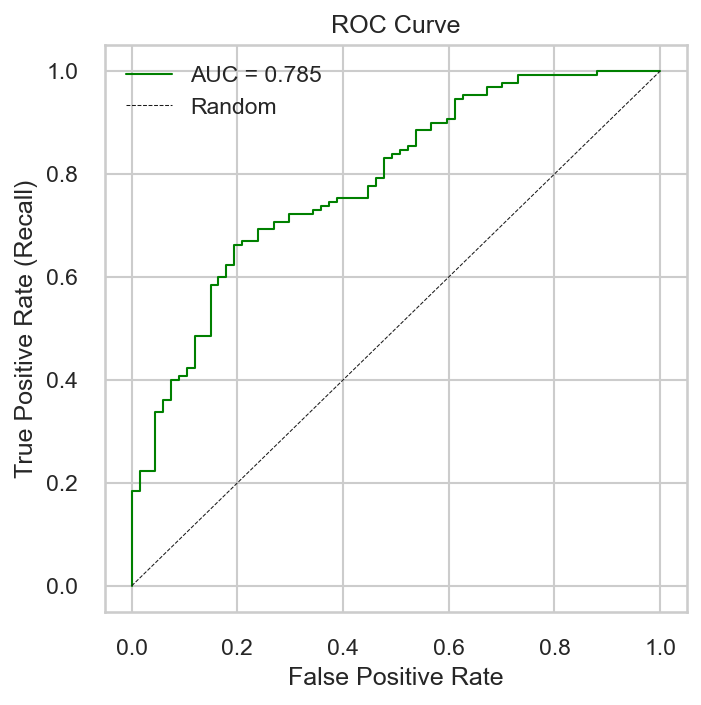

<Figure size 360x360 with 0 Axes>

In [1323]:
# ROC Curve/ AUC Score
print("Start GB ROC Plot")

## Call Function
ROC_Curve_Plot(gb,x_test, y_test) # model, x_test, y_test
plt.show()
plt.savefig(plotLoc+'GB_ROC.png')

Start GB Feature Importance


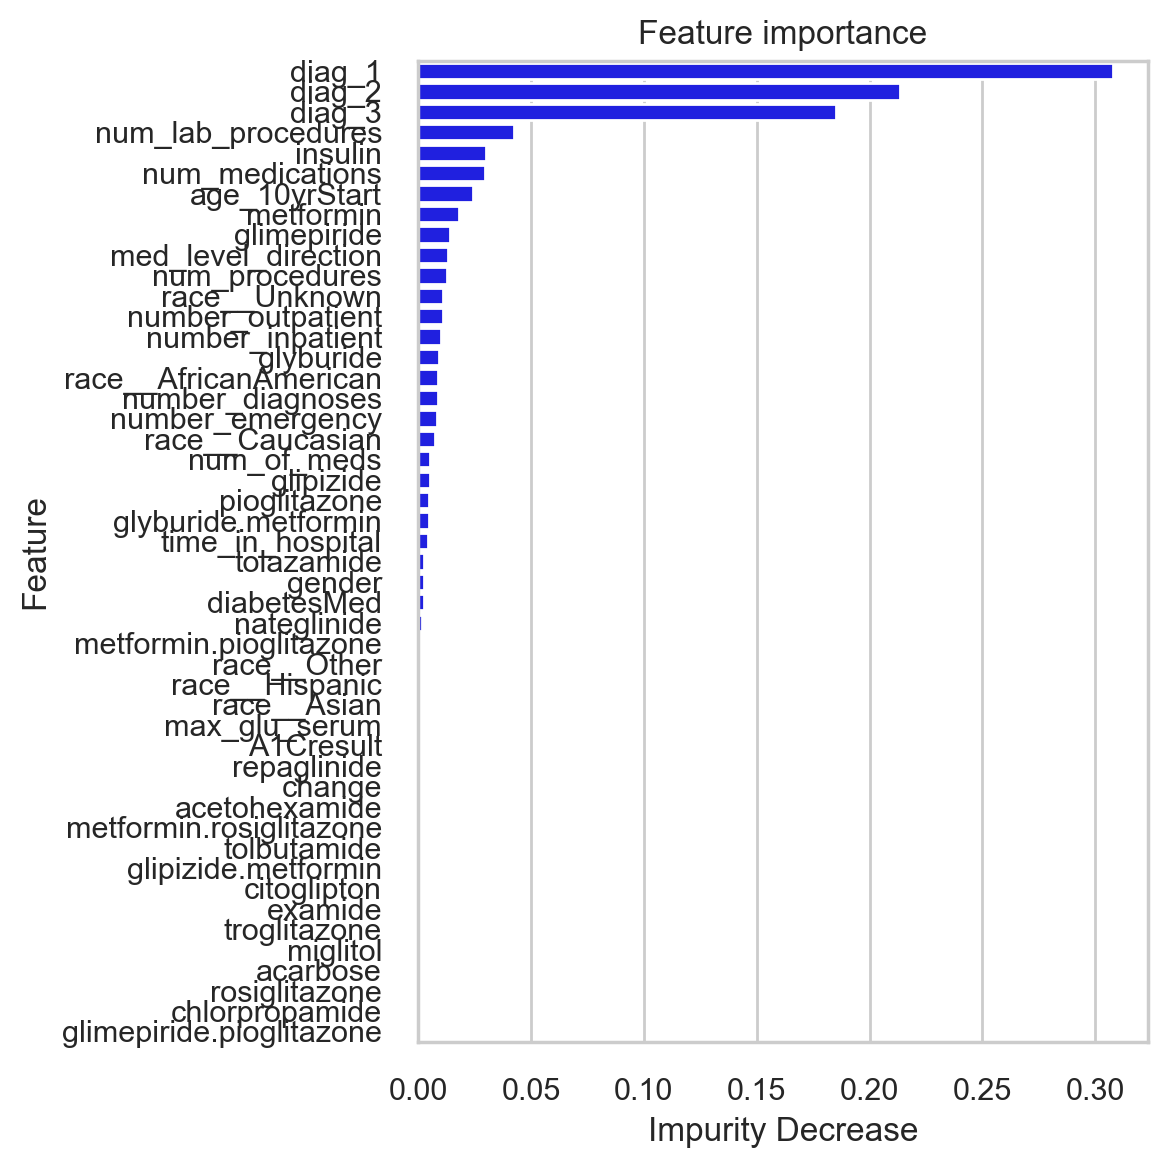

In [1324]:
# Random Forest -- Feature Importance -- Plot Most Important Features
print("Start GB Feature Importance")

feature_importances, fig = FeatureImportance(gb,featureList) #model, featureList
fig.show()
plt.savefig(plotLoc+'GB_Feature-Importance.png')

## Neural Network

In [1325]:
print("starting N.N. Classifier")
nn = MLPClassifier(hidden_layer_sizes=(256,128,64,32),
                   activation="relu",random_state=1)
nn.fit(x_train_Active, y_train_Active)
y_pred_nn = nn.predict(x_test_Active)
print(nn.score(x_test_Active, y_test_Active))

starting N.N. Classifier
0.6548223350253807


start plot


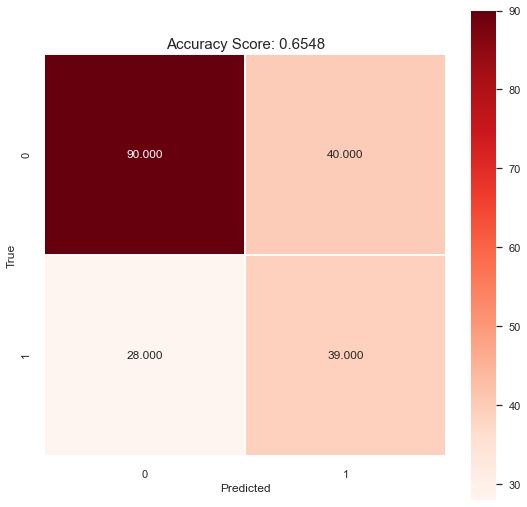

In [1326]:
# N.N -- Plot CM
print("start plot")
cm, score = createConfMatrix(nn,y_test_Active, y_pred_nn, x_test_Active) #model, y_test, y_pred, x_test

# plot result
plt.figure(figsize=(9,9))
fig= sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Reds');
all_sample_title = "Accuracy Score: " + score.astype('str')
plt.title(all_sample_title, size = 15);
plt.savefig(plotLoc+'NN_CM.png')

In [1327]:
# N.N -- Precision/Recall Scores
## Set Params
model_name = "Neural Network"

## Call Function
summaryDF = summaryStats(model_name,y_test_Active, y_pred_nn, summaryStatsDF) # modelName(str), y_test, y_pred, df
summaryDF

,Model,Accuracy,Precision,Recall,F1
0,Random Forest,0.7310,0.6000,0.6269,0.6131
1,Gradient Boost,0.7056,0.5600,0.6269,0.5915
2,Neural Network,0.6548,0.4937,0.5821,0.5342


N.N ROC Plot


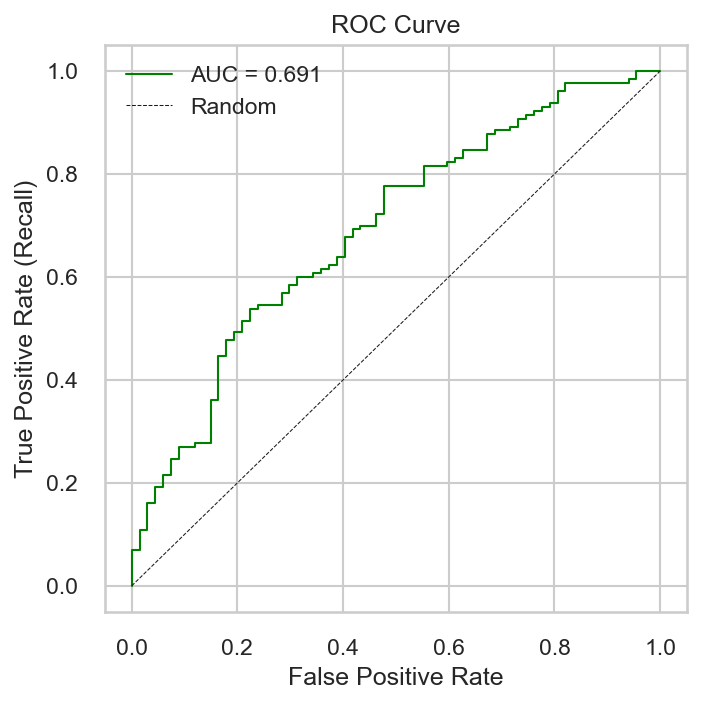

<Figure size 360x360 with 0 Axes>

In [1328]:
# ROC Curve/ AUC Score
print("N.N ROC Plot")
## Set Params

## Call Function
ROC_Curve_Plot(nn,x_test_Active, y_test_Active) # model, x_test, y_test
plt.show()
plt.savefig(plotLoc+'NN_ROC.png')

## Compare all Models

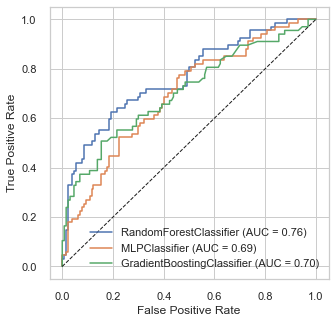

In [1329]:
# Plot First Model:
disp = plot_roc_curve(rf,x_test_Active,y_test_Active)
# To Add More Models, copy line below and replace model name:
# plot_roc_curve(knn,x_test,y_test, ax=disp.ax_)
plot_roc_curve(nn,x_test_Active,y_test_Active, ax=disp.ax_)
plot_roc_curve(gb,x_test_Active,y_test_Active, ax=disp.ax_)
# plot Random Line
plt.plot([0,1], [0,1], '--k', lw=1.0, label='Random')

plt.savefig(plotLoc +'ROC-Compare.png')

In [1343]:
# Write Summary Reports to Excel
with pd.ExcelWriter(exportPath + 'Model_QuickEval.xlsx') as writer:
    qe_summaryDF.to_excel(writer, sheet_name='QuickEval_noPCA')
    qe_summaryDF_wPCA.to_excel(writer, sheet_name='QuickEval_PCA')
    summaryDF.to_excel(writer, sheet_name='Full-Model-Summary')
print("Export Complete")

Export Complete


## K-Means Clustering

In [1330]:
# Make a copy of the DF
k_means_df = tempModelingDF
k_means_df = k_means_df.drop(columns=['readmitted'])


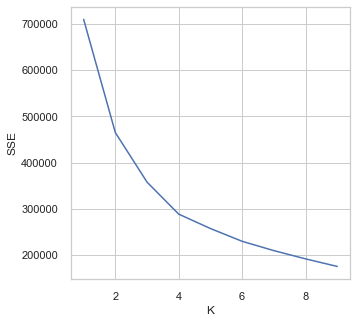

In [1331]:
# Call Elbow Plot Function
KMeansElbowPlot(k_means_df)
plt.show()

In [1332]:
# K-Means - set number of clusters based on elbow
km = KMeans(n_clusters=4)
km

KMeans(n_clusters=4)

In [1333]:
# Scale Data using min max scaler

scaler = MinMaxScaler()
colNames = k_means_df.columns.values.tolist()

for column in k_means_df[colNames]:
    scaler.fit(k_means_df[[column]])
    k_means_df[column] = scaler.transform(k_means_df[[column]])

k_means_df.head()

,gender,age_10yrStart,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,...,change,diabetesMed,num_of_meds,med_level_direction,race__AfricanAmerican,race__Asian,race__Caucasian,race__Hispanic,race__Other,race__Unknown
0,0.0,1.000000,0.461538,0.428571,0.000000,0.181818,0.2,0.0,0.000000,0.319566,...,0.0,1.0,0.2,0.50,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.444444,1.000000,0.419643,0.833333,0.527273,0.0,0.0,0.000000,0.472823,...,0.0,0.0,0.0,0.50,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.000000,0.384615,0.383929,0.000000,0.200000,0.0,0.0,0.166667,0.400521,...,1.0,1.0,0.4,0.25,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.777778,0.769231,0.553571,0.333333,0.327273,0.0,0.0,0.000000,0.400838,...,0.0,0.0,0.0,0.50,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.777778,0.846154,0.607143,0.166667,0.163636,0.0,0.0,0.000000,0.318357,...,0.0,1.0,0.2,0.50,0.0,0.0,0.0,0.0,0.0,1.0


In [1334]:
# Re-Train Dataset using Scaled Data
y_predicted = km.fit_predict(k_means_df[colNames])
k_means_df['Cluster'] = y_predicted
k_means_df['Cluster'].value_counts(dropna=False)

2    352
1    266
3    196
0    170
Name: Cluster, dtype: int64

In [1335]:
#Merge clusters ("Temp") back with the preserved original DF
tempModelingDF = pd.merge(tempModelingDF, k_means_df[['Cluster']], left_index=True, right_index=True)
tempModelingDF.head()

,gender,age_10yrStart,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,...,num_of_meds,med_level_direction,race__AfricanAmerican,race__Asian,race__Caucasian,race__Hispanic,race__Other,race__Unknown,readmitted,Cluster
0,0,90,7,49,0,11,2,0,0,0.322581,...,1,0,0,0,1,0,0,0,1,1
1,1,40,14,48,5,30,0,0,0,0.468569,...,0,0,0,0,1,0,0,0,0,3
2,0,90,6,44,0,12,0,0,1,0.399697,...,2,-1,1,0,0,0,0,0,1,0
3,1,70,11,63,2,19,0,0,0,0.399998,...,0,0,0,0,1,0,0,0,1,3
4,0,70,12,69,1,10,0,0,0,0.321429,...,1,0,0,0,0,0,0,1,0,1


No handles with labels found to put in legend.


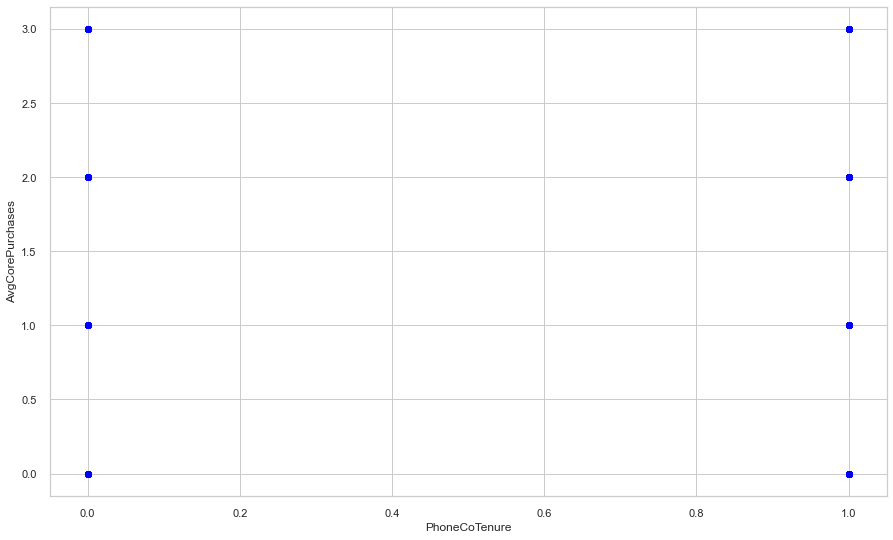

In [1336]:
# TODO -- Need to refactor, useless right now.

# Replot on scatterplot using scaled data -- Include Centroid Clusters
# Set each cluster as a dataframe
cluster0 = tempModelingDF[tempModelingDF['Cluster'] == 0]
cluster1 = tempModelingDF[tempModelingDF['Cluster'] == 1]
cluster2 = tempModelingDF[tempModelingDF['Cluster'] == 2]
cluster3 = tempModelingDF[tempModelingDF['Cluster'] == 3]

fig_dims = (15, 9)
fig, ax = plt.subplots(figsize=fig_dims)

plt.scatter(tempModelingDF['readmitted'],tempModelingDF['Cluster'], color='blue',alpha=0.2)
#plt.scatter(cluster1['readmitted'],cluster1['Cluster'], color='green',alpha=0.2)
#plt.scatter(cluster2['readmitted'],cluster2['Cluster'], color='yellow',alpha=0.2)
#plt.scatter(cluster3['readmitted'],cluster2['Cluster'], color='orange',alpha=0.2)
#plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],color='red',marker='*', label='centroid')

plt.xlabel('PhoneCoTenure')
plt.ylabel('AvgCorePurchases')
plt.legend()

#### Summary -- Describe Clusters

* Some ideas: https://www.bigendiandata.com/2017-04-18-Jupyter_Customer360/

# Experimentation/ Scratchpad

In [1337]:
expData.sample(10)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide.metformin,glipizide.metformin,glimepiride.pioglitazone,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,readmitted
26299,419589950,33276294,Caucasian,Male,[50-60),NaN,3,6,1,14,...,No,Down,No,No,No,No,No,Ch,Yes,NO
27747,298340768,37386396,Caucasian,Male,[60-70),NaN,1,1,7,2,...,No,Down,No,No,No,No,No,Ch,Yes,>30
69986,329613680,141383120,Caucasian,Female,[40-50),NaN,1,6,7,9,...,No,Down,No,No,No,No,No,Ch,Yes,NO
64806,183767802,105810795,Caucasian,Male,[70-80),NaN,3,6,7,6,...,No,Steady,Steady,No,No,No,No,Ch,Yes,>30
27096,329554718,35368398,Caucasian,Female,[70-80),NaN,1,1,7,5,...,No,Steady,No,No,No,No,No,No,Yes,NO
12354,62705190,14631039,Caucasian,Male,[30-40),NaN,2,18,4,10,...,No,No,No,No,No,No,No,No,Yes,NO
14285,36345342,18790353,Caucasian,Male,[30-40),NaN,3,1,4,3,...,No,No,No,No,No,No,No,No,Yes,NO
4310,12468768,2270349,Caucasian,Male,[70-80),NaN,3,4,20,8,...,No,Up,No,No,No,No,No,Ch,Yes,NO
14579,57192894,19103886,Caucasian,Male,[60-70),NaN,2,6,1,6,...,No,Steady,No,No,No,No,No,No,Yes,NO
21784,105595098,24733116,Caucasian,Female,[70-80),NaN,3,1,1,1,...,No,No,No,No,No,No,No,No,Yes,>30


In [1338]:
#TODO - 1) Remove Response Vars from check 2) pull higher up probably in EDA

responseVar = 'readmitted'
corr = round(tempModelingDF.corr(),4)
corr = abs(corr[responseVar]).sort_values(ascending=False)

#Selecting highly correlated features
relevant_features = corr[corr>=0.04] # Look for Features w/ greater 0.05 cor
relevant_features

readmitted             1.0000
diag_1                 0.3800
diag_3                 0.3309
diag_2                 0.3265
number_inpatient       0.1364
number_diagnoses       0.1020
age_10yrStart          0.0864
num_lab_procedures     0.0651
gender                 0.0623
glyburide.metformin    0.0613
num_procedures         0.0581
number_emergency       0.0549
insulin                0.0491
time_in_hospital       0.0462
Name: readmitted, dtype: float64

In [1339]:
#TEMP - Reduce to corrlated features.  If use this, then need to implement in a way that isn't manually keying in.
relevant_features_df = tempModelingDF[['readmitted','number_inpatient','number_emergency',
                                                      'age_10yrStart','number_outpatient','time_in_hospital',
                                                      'num_lab_procedures']]
relevant_features_df


,readmitted,number_inpatient,number_emergency,age_10yrStart,number_outpatient,time_in_hospital,num_lab_procedures
0,1,0,0,90,2,7,49
1,0,0,0,40,0,14,48
2,1,1,0,90,0,6,44
3,1,0,0,70,0,11,63
4,0,0,0,70,0,12,69
...,...,...,...,...,...,...,...
979,1,1,0,60,0,7,59
980,0,0,0,50,0,1,45
981,0,0,0,80,0,1,42
982,0,0,0,70,1,5,36


In [1340]:
mainData['gender'].value_counts(dropna=False)

Female    530
Male      470
Name: gender, dtype: int64

In [1341]:
expVars = ['num_of_meds','med_level_direction','metformin','repaglinide','nateglinide','chlorpropamide','glimepiride',
            'acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone',
            'rosiglitazone','acarbose','miglitol','troglitazone','tolazamide','examide',
            'citoglipton','insulin','glyburide.metformin','glipizide.metformin','glimepiride.pioglitazone',
            'metformin.rosiglitazone','metformin.pioglitazone','readmitted']

expSummaryVars = ['num_of_meds','med_level_direction','readmitted']

tempCor = mainData[expSummaryVars]
tempCor.sample(5)

KeyError: "['med_level_direction', 'num_of_meds'] not in index"

In [ ]:
#Multiple Regression -- Check Correlations in HeatMap
plt.figure(figsize=(12,10))
cor = round(tempCor.corr(),3)
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)

In [ ]:
#Multiple Regressions -- Correlation with output variable
responseVar = 'readmitted'
cor_target = abs(cor[responseVar])
#Selecting highly correlated features
#relevant_features = cor_target[cor_target>=0.01] # Look for Features w/ greater 0.05 cor
#relevant_features
cor_target

In [ ]:
mainData.shape

In [ ]:
mainData['max_glu_serum'].value_counts(dropna=False)

# Archive


### KNN

print("starting KNN")
# KNN -- Find Best K-Value
row =[]
knn_bestK = pd.DataFrame(columns = ["k","testScore","MSE","RMSE"])

for k in range(1,11):
    knn = KNeighborsClassifier(n_neighbors=k) # Update K
    knn.fit(x_train, y_train) ## Fit Data
    knn_best_yPred = knn.predict(x_test)
    MSE = round(mean_squared_error(y_test,knn_best_yPred),4)
    RMSE = round(np.sqrt(MSE))
    TestScore = knn.score(x_test, y_test)
    row = [k,TestScore,MSE,RMSE]
    df_length = len(knn_bestK)
    knn_bestK.loc[df_length] = row
knn_bestK

sns.set_style("whitegrid")
fig, (ax1,ax2) = plt.subplots(ncols=2,sharex=True, sharey=False, figsize=(15,9))

sns.lineplot(
    data=knn_bestK, ax=ax1,
    x="k", y="testScore",
    dashes=False)

sns.lineplot(
    data=knn_bestK, ax=ax2,
    x="k", y="MSE",
    dashes=False)

plt.show()

print("Starting KNN Prediction")
# KNN -- Create Regression Object. Fit Data, Make predictions
knn = KNeighborsClassifier(n_neighbors=6) # Update K
knn.fit(x_train, y_train) ## Fit Data
y_pred_knn = knn.predict(x_test)
print("Done w/ KNN Prediction")


# KNN -- CM

print("start plot")
# KNN -- Plot CM
cm, score = createConfMatrix(knn, y_test, y_pred_knn, x_test) # model, y_test, y_pred, x_test

# plot result
plt.figure(figsize=(9,9))
fig= sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Reds');
all_sample_title = "Accuracy Score: " + score.astype('str')
plt.title(all_sample_title, size = 15);

plt.savefig(plotLoc+'KNN_CM.png')

# KNN -- Precision/Recall Scores
## Set Params
model_name = "K Nearest Neighbors"

## Call Function
summaryDF = summaryStats(model_name,y_test, y_pred_knn, summaryStatsDF) # modelName(str), y_test, y_pred, df
summaryDF

# ROC Curve/ AUC Score
print("K.N.N ROC Plot")

## Call Function
ROC_Curve_Plot(knn,x_test, y_test) # model, x_test, y_test
plt.show()

plt.savefig(plotLoc+'KNN_ROC.png')